In [2]:
# Import modules
import numpy as np
from qiskit import(
    QuantumCircuit,
    execute,
    Aer,
    QuantumRegister,
    ClassicalRegister
    )

from qiskit.visualization import plot_histogram

In [3]:
# Define our registers and circuit
qb = QuantumRegister(5, 'code_qubit')     # The 5 qubits to encode the state in
an = QuantumRegister(2, 'ancilla_qubit')  # The two ancilla qubits (one of them is unused)
cr = ClassicalRegister(4, 'syndrome_bit') # Classical register for registering the syndromes
readout = ClassicalRegister(5, 'readout') # Readout of the final state at the end for statistics

In [9]:
# Note that some gates might be redundant, haven't checked
def encode_input( qbReg ):
    '''Encode the input into logical 0 and 1
    This assumes that the 0:th qubit is the
    original state |psi> = a|0> + b|1>'''
    encoding_circuit = QuantumCircuit( qbReg )

    encoding_circuit.h( qbReg[3] )
    encoding_circuit.cz( qbReg[3], qbReg[1] )
    encoding_circuit.cz( qbReg[3], qbReg[2] )
    encoding_circuit.cx( qbReg[3], qbReg[0] )   

    encoding_circuit.h( qbReg[2] )
    encoding_circuit.cx( qbReg[2], qbReg[0] )
    encoding_circuit.cz( qbReg[2], qbReg[3] )
    encoding_circuit.cz( qbReg[2], qbReg[4] )
    
    encoding_circuit.h( qbReg[1] )
    encoding_circuit.cz( qbReg[1], qbReg[0] )
    encoding_circuit.cx( qbReg[1], qbReg[3] )
    encoding_circuit.cz( qbReg[1], qbReg[4] )
    
    encoding_circuit.h( qbReg[4] )
    encoding_circuit.cz( qbReg[4], qbReg[2] )
    encoding_circuit.cz( qbReg[4], qbReg[3] )
    encoding_circuit.cx( qbReg[4], qbReg[1] )
    
    encoding_circuit.barrier( qbReg )
    return encoding_circuit

# Define our stabilizers
def measure_stabilizer( qbReg, anReg, clReg, i ):
    '''Function for adding stabilizer measurements to a circuit.
    Note that a measurement of X is done by using Hadamard before
    and after. Input i specifies the stabilizer to measure:
        i=0: XZZXI
        i=1: IXZZX
        i=2: XIXZZ
        i=3: ZXIXZ
    Other inputs are the circuit as well as the required registers'''
    
    if not isinstance(i, int):
        raise error('i must be an integer')
    
    stab_circuit = QuantumCircuit( qbReg, anReg, clReg )

    # Generate indexes
    index = np.mod( i + np.array([0, 1, 2, 3]), 5 ) 
    
    # Measure stabilizers
    stab_circuit.h( qbReg[ index[0] ] )
    stab_circuit.h( anReg[0] )
    stab_circuit.cz( anReg[0], qbReg[ index[0] ] )
    stab_circuit.h( qbReg[ index[0] ] ) 
    
    stab_circuit.cz( anReg[0], qbReg[ index[1] ] )

    stab_circuit.cz( anReg[0], qbReg[ index[2] ] )
        
    stab_circuit.h( qbReg[ index[3] ] )
    stab_circuit.cz( anReg[0], qbReg[ index[3] ] )
    stab_circuit.h( anReg[0] )
    stab_circuit.h( qbReg[ index[3] ] ) 
        
    stab_circuit.measure( anReg[0], clReg[i] )
    stab_circuit.reset( anReg[0] )
    return stab_circuit

def run_stabilizer( qbReg, anReg, clReg ):
    stab_circuit = QuantumCircuit( qbReg, anReg, clReg )
    stab_circuit += measure_stabilizer( qbReg, anReg, clReg, 0 )
    stab_circuit += measure_stabilizer( qbReg, anReg, clReg, 1 )
    stab_circuit += measure_stabilizer( qbReg, anReg, clReg, 2 )
    stab_circuit += measure_stabilizer( qbReg, anReg, clReg, 3 )
    return stab_circuit

# Correct possible errors
def recovery_scheme( qbReg, clReg ):

    recovery_circuit = QuantumCircuit( qbReg, clReg )
    recovery_circuit.x(qbReg[1]).c_if(clReg, 1)
    recovery_circuit.z(qbReg[4]).c_if(clReg, 2)
    recovery_circuit.x(qbReg[2]).c_if(clReg, 3)
    recovery_circuit.z(qbReg[2]).c_if(clReg, 4)
    recovery_circuit.z(qbReg[0]).c_if(clReg, 5)
    recovery_circuit.x(qbReg[3]).c_if(clReg, 6)
    recovery_circuit.x(qbReg[2]).c_if(clReg, 7)
    recovery_circuit.z(qbReg[2]).c_if(clReg, 7)
    recovery_circuit.x(qbReg[0]).c_if(clReg, 8)
    recovery_circuit.z(qbReg[3]).c_if(clReg, 9)
    recovery_circuit.z(qbReg[1]).c_if(clReg, 10)
    recovery_circuit.x(qbReg[1]).c_if(clReg, 11)
    recovery_circuit.z(qbReg[1]).c_if(clReg, 11)
    recovery_circuit.x(qbReg[4]).c_if(clReg, 12)
    recovery_circuit.x(qbReg[0]).c_if(clReg, 13)
    recovery_circuit.z(qbReg[0]).c_if(clReg, 13)
    recovery_circuit.x(qbReg[4]).c_if(clReg, 14)
    recovery_circuit.z(qbReg[4]).c_if(clReg, 14)
    recovery_circuit.x(qbReg[3]).c_if(clReg, 15)
    recovery_circuit.z(qbReg[3]).c_if(clReg, 15)

    return recovery_circuit


{'10001 1001': 35, '10001 1111': 27, '10010 1001': 32, '10010 1111': 31, '10100 1001': 41, '10100 1111': 36, '10111 1001': 30, '10111 1111': 30, '11000 1001': 31, '11000 1111': 36, '11011 1001': 35, '11011 1111': 19, '11101 1001': 38, '11101 1111': 33, '11110 1001': 26, '11110 1111': 33, '00011 1001': 27, '00011 1111': 32, '00101 1001': 24, '00101 1111': 34, '00110 1001': 33, '00110 1111': 44, '00000 1001': 34, '01001 1001': 33, '01001 1111': 28, '01010 1001': 21, '01010 1111': 35, '01100 1001': 39, '01100 1111': 30, '00000 1111': 33, '01111 1001': 35, '01111 1111': 29}


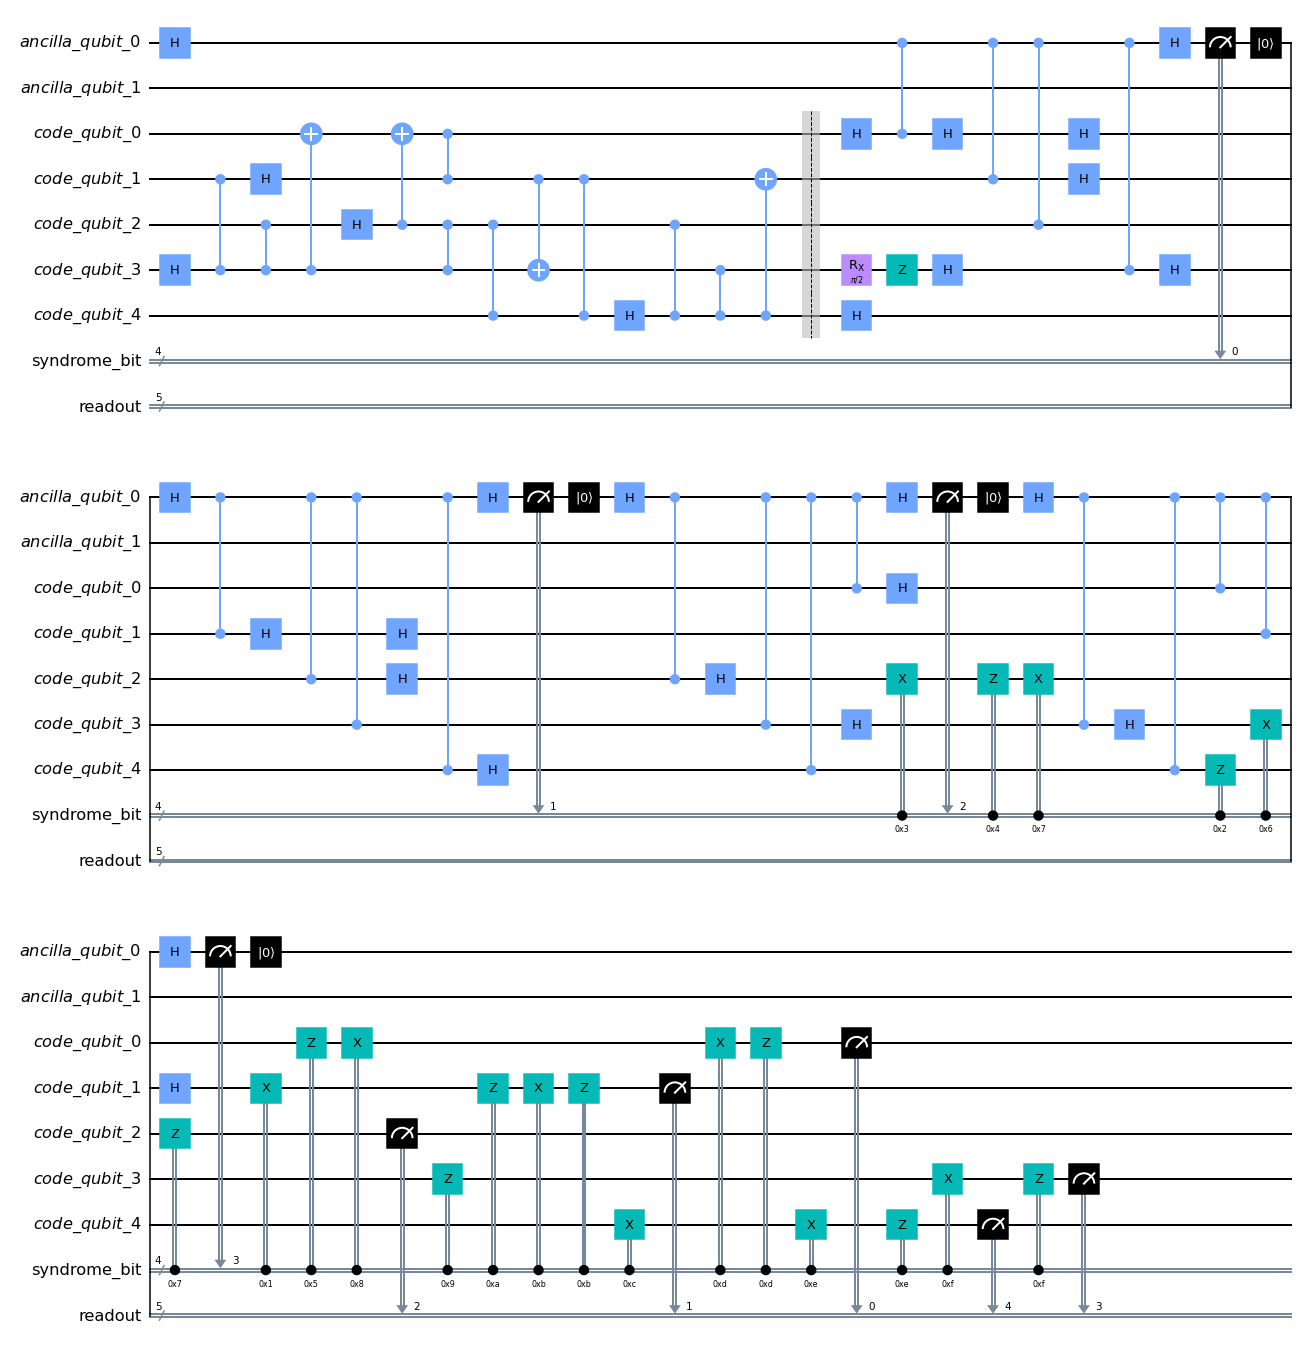

In [12]:
circuit = QuantumCircuit( cr, readout, an, qb )

# Prepare the input
#circuit.x( qb[0] ) # As an example, start in |1>

# Encode the state
circuit += encode_input( qb ) 

# Add errors manually
circuit.rx( np.pi/2, qb[3] )
circuit.z( qb[3] )

# Measure stabilizers
circuit += run_stabilizer( qb, an, cr )

# Correct the error
circuit += recovery_scheme( qb, cr )

#run_stabilizer( circuit, qb, an, cr )
# Readout of the encoded state
circuit.measure( qb, readout )

counts = execute(circuit, Aer.get_backend('qasm_simulator')).result().get_counts()
print(counts)

circuit.draw(output='mpl') # If it does not work, simply remove mpl: circuit.draw()
#plot_histogram(counts)
